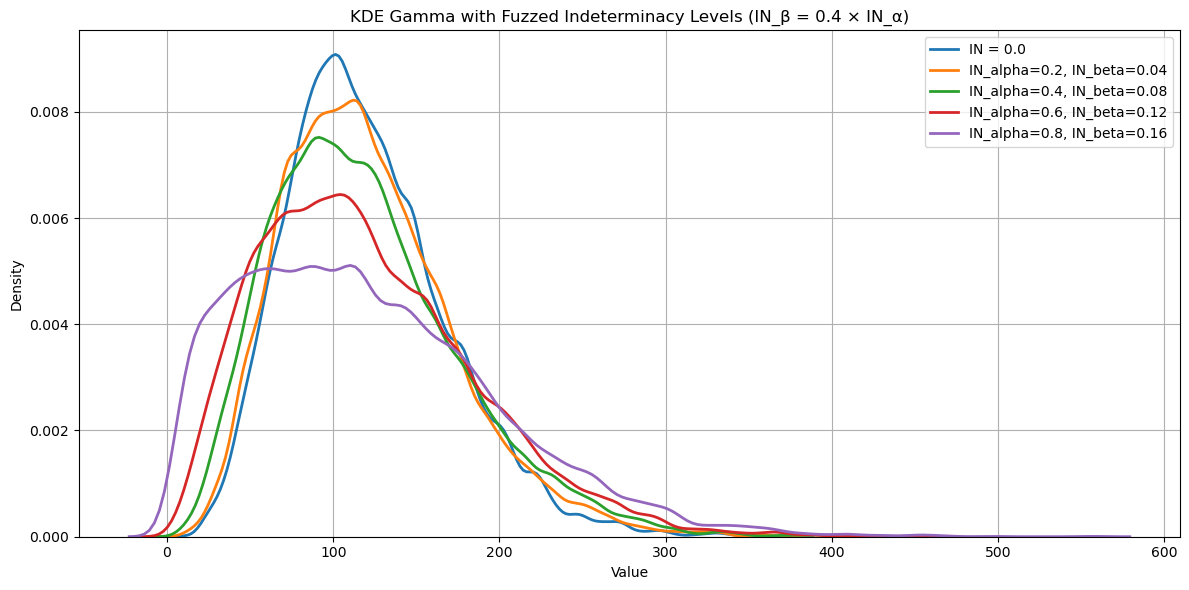

===== Thống kê mô tả từng mức IN =====

IN = 0.0
  Mean     : 120.8180
  Std      : 48.4722
  Skewness : 0.8032
  Kurtosis : 1.1059
  Min/Max  : 8.9721 / 374.0852

IN_alpha=0.2, IN_beta=0.04
  Mean     : 121.1067
  Std      : 51.7288
  Skewness : 0.8672
  Kurtosis : 1.2657
  Min/Max  : 11.1400 / 394.2386

IN_alpha=0.4, IN_beta=0.08
  Mean     : 119.6407
  Std      : 56.9768
  Skewness : 0.8523
  Kurtosis : 0.9621
  Min/Max  : 9.2435 / 423.9681

IN_alpha=0.6, IN_beta=0.12
  Mean     : 119.8496
  Std      : 64.1914
  Skewness : 0.7777
  Kurtosis : 0.6245
  Min/Max  : 2.1031 / 456.9896

IN_alpha=0.8, IN_beta=0.16
  Mean     : 120.0123
  Std      : 75.9736
  Skewness : 0.7985
  Kurtosis : 0.6470
  Min/Max  : 0.0115 / 556.4779

===== KS-test với baseline IN = 0 =====
IN_alpha=0.2, IN_beta=0.04 vs IN = 0.0 --> KS statistic = 0.0271, p-value = 0.0000
IN_alpha=0.4, IN_beta=0.08 vs IN = 0.0 --> KS statistic = 0.0690, p-value = 0.0000
IN_alpha=0.6, IN_beta=0.12 vs IN = 0.0 --> KS statistic = 0.1

In [2]:
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, kstest

# Initialize Spark session
spark = SparkSession.builder.appName("GammaNeutrosophic").getOrCreate()

np.random.seed(42)

def generate_classic_gamma_spark(alpha, beta, size):
    def generate_sample(_):
        return float(np.random.gamma(shape=alpha, scale=1 / beta))
    rdd = spark.sparkContext.parallelize(range(size)).map(generate_sample)
    return spark.createDataFrame([(x,) for x in rdd.collect()], ["value"])

def generate_fuzzed_gamma_spark(alpha, beta, IN_alpha, k, size):
    IN_beta = k * IN_alpha  # Đảo ngược: IN_beta = k * IN_alpha
    def generate_sample(_):
        alpha_rand = np.random.uniform(alpha - alpha * IN_alpha, alpha + alpha * IN_alpha)
        beta_rand = max(0.01, np.random.uniform(beta - beta * IN_beta, beta + beta * IN_beta))
        return float(np.random.gamma(shape=alpha_rand, scale=1 / beta_rand))
    rdd = spark.sparkContext.parallelize(range(size)).map(generate_sample)
    return spark.createDataFrame([(x,) for x in rdd.collect()], ["value"])

alpha, beta, size = 6, 0.05, 100000
IN_alpha_levels = [0.0, 0.2, 0.4, 0.6, 0.8]
k = 0.2  # Tỉ lệ IN_beta/IN_alpha

data_dict = {}
for IN_alpha in IN_alpha_levels:
    if IN_alpha == 0.0:
        data_dict["IN = 0.0"] = generate_classic_gamma_spark(alpha, beta, size).collect()
        data_dict["IN = 0.0"] = [row["value"] for row in data_dict["IN = 0.0"]]
    else:
        label = f"IN_alpha={IN_alpha}, IN_beta={k*IN_alpha:.2f}"
        data_dict[label] = generate_fuzzed_gamma_spark(alpha, beta, IN_alpha, k, size).collect()
        data_dict[label] = [row["value"] for row in data_dict[label]]

# Vẽ KDE
plt.figure(figsize=(12, 6))
for label, data in data_dict.items():
    sns.kdeplot(data, label=label, linewidth=2)
plt.title("KDE Gamma with Fuzzed Indeterminacy Levels (IN_β = 0.4 × IN_α)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Đánh giá thống kê
print("===== Thống kê mô tả từng mức IN =====")
for label, data in data_dict.items():
    print(f"\n{label}")
    print(f"  Mean     : {np.mean(data):.4f}")
    print(f"  Std      : {np.std(data):.4f}")
    print(f"  Skewness : {skew(data):.4f}")
    print(f"  Kurtosis : {kurtosis(data):.4f}")
    print(f"  Min/Max  : {np.min(data):.4f} / {np.max(data):.4f}")

# So sánh bằng KS-test
print("\n===== KS-test với baseline IN = 0 =====")
baseline = data_dict["IN = 0.0"]
for label, data in data_dict.items():
    if label == "IN = 0.0":
        continue
    stat, p = kstest(data, baseline)
    print(f"{label} vs IN = 0.0 --> KS statistic = {stat:.4f}, p-value = {p:.4f}")

spark.stop()